# Sample design: D-optimal

In [241]:
from pathlib import Path
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import shapely
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
import geopandas as gpd
import xarray as xr

from sklearn import cluster
from sklearn import neighbors
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn import metrics, cluster

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import ShuffleSplit, GroupKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import KBinsDiscretizer

import cvxpy as cp

In [93]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

## Read in and merge data

In [4]:
# read in chlorophyl chunks
c_path = data_clean_path / 'chlor_a_monthly'
c_files = [f for f in os.listdir(c_path) if f.endswith('.csv.gz')]
c_files.sort()
print('files to read:', len(c_files))
c_raw = pd.DataFrame()
for f in tqdm(c_files):
    c = pd.read_csv(data_clean_path / 'chlor_a_monthly' / f)
    c_raw = pd.concat([c, c_raw])

files to read: 9


100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.65s/it]


In [5]:
# read in temperature chunks
t_path = data_clean_path / 'sst_monthly'
t_files = [f for f in os.listdir(t_path) if f.endswith('.csv.gz')]
t_files.sort()
print('files to read:', len(t_files))
t_raw = pd.DataFrame()
for f in tqdm(t_files):
    t = pd.read_csv(data_clean_path / 'sst_monthly' / f)
    t_raw = pd.concat([t, t_raw])

files to read: 9


100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.59s/it]


In [6]:
# read in pc02
p_raw = pd.read_csv(data_clean_path / 'ship_pc02_monthly.csv.gz')

In [7]:
# merge on x/y values
m = pd.merge(left=p_raw, right=c_raw, how='left', on=['x', 'y', 'year', 'month'], suffixes=('_p', '_c'))
m = pd.merge(left=m, right=t_raw, how='left', on=['x', 'y', 'year', 'month'], suffixes=('', '_t'))
print('Merged data shape:', m.shape)
# drop any missing
m_sub = m.loc[m.chlor_a_cln.notna() & m.sst_cln.notna()]
print('Merged data shape after dropping missing:', m_sub.shape)

Merged data shape: (155726, 29)
Merged data shape after dropping missing: (154701, 29)


In [8]:
# read annual data
t_annual_raw = pd.read_csv(data_clean_path / 'sst_annual.csv')
c_annual_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

In [9]:
# merge on x/y values
m_sub = pd.merge(left=m_sub, right=t_annual_raw, on=['x', 'y', 'year'], suffixes=('', '_ta'))
m_sub = pd.merge(left=m_sub, right=c_annual_raw, on=['x', 'y', 'year'], suffixes=('', '_ca'))

In [27]:
# read in full data and merge
t_raw = pd.read_csv(data_clean_path / 'sst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
o_m = pd.merge(left=t_raw, right=c_raw, how='inner', on=['x', 'y'], suffixes=('_t', '_c'))

geometry = [Point(xy) for xy in zip(o_m.lon_t, o_m.lat_t)]
geo_m = gpd.GeoDataFrame(o_m, geometry=geometry, crs=geo_crs)

## Make X, y input datasets

In [291]:
response_col = 'pco2_teq'
y = m_sub[response_col]
X = m_sub.drop(columns=response_col)

## Cross validate each regression approach
See template [here](https://github.com/etrieschman/indigo-soil-imputation/blob/master/notebooks/cross_val_interpolators_v2.ipynb)
* Global mean
* Ocean mean
* KNN
* Linear regression
* Elastic net regression (Lasso vs. Ridge regression)
* AdaBoost regression
* https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

In [292]:
def bias(y_true, y_pred):
    """Return the estimated bias of the predictions
    (the average of prediction - truth)"""
    return (y_pred - y_true).mean()

In [293]:
scoring = dict(
    neg_mean_squared_error='neg_mean_squared_error',
#     bias=metrics.make_scorer(bias),
    r_squared='r2'
)

In [310]:
predictor_vars = ['pacific', 'month', 'year', 'chlor_a_cln', 'sst_cln', 'months_below_mean', 'max', 'std', 'max_ca', 'std_ca']
response_var = 'pco2_teq'

### Group lat/lons for cross validation

In [309]:
CLUSTERS = 20
cl = cluster.KMeans(n_clusters=CLUSTERS)
cl.fit(m_sub.loc[m_sub.pacific, ['x', 'y']])
X_pac['kmeans_cluster'] = cl.labels_
cl.fit(m_sub.loc[m_sub.pacific==False,['x', 'y']])
X_atl['kmeans_cluster'] = cl.labels_

In [321]:
# global mean
params={}
estimator=DummyRegressor()

# run grid search for hyperparameters
grid_search = GridSearchCV(
            estimator=estimator, 
            param_grid=params,
            scoring=scoring,
            refit=False, 
            cv=GroupKFold(n_splits=CLUSTERS), 
            verbose=0, 
            return_train_score=False
)

cv_summ = pd.DataFrame()
for ocean in [True, False]:
    
    df = m_sub.loc[m_sub.pacific==ocean]
    cl.fit(df[['x', 'y']])
    df['kmeans_cluster'] = cl.labels_
    
    cv = grid_search.fit(df[predictor_vars], df[response_var], groups=df['kmeans_cluster'])

    cv = pd.DataFrame({'pacific': [ocean]*len(cv.cv_results_['params']),
        'model': [str(estimator)]*len(cv.cv_results_['params']),
        'params': cv.cv_results_['params'],
        'mean_test_neg_mean_squared_error': cv.cv_results_['mean_test_neg_mean_squared_error'],
        'mean_test_r_squared': cv.cv_results_['mean_test_r_squared']}).sort_values('mean_test_neg_mean_squared_error')
    cv_summ = pd.concat([cv, cv_summ])

dr_cv_summ = cv_summ
dr_cv_summ

,pacific,model,params,mean_test_neg_mean_squared_error,mean_test_r_squared
0,False,DummyRegressor(),{},-1193.774335,-0.527620
0,True,DummyRegressor(),{},-1890.861946,-1.694506


In [322]:
# linear regression
params={'fit_intercept':[True, False]}
estimator=LinearRegression()

# run grid search for hyperparameters
grid_search = GridSearchCV(
            estimator=estimator, 
            param_grid=params,
            scoring=scoring,
            refit=False, 
            cv=GroupKFold(n_splits=CLUSTERS), 
            verbose=0, 
            return_train_score=False
)

cv_summ = pd.DataFrame()
for ocean in [True, False]:
    
    df = m_sub.loc[m_sub.pacific==ocean]
    cl.fit(df[['x', 'y']])
    df['kmeans_cluster'] = cl.labels_
    
    cv = grid_search.fit(df[predictor_vars], df[response_var], groups=df['kmeans_cluster'])

    cv = pd.DataFrame({'pacific': [ocean]*len(cv.cv_results_['params']),
        'model': [str(estimator)]*len(cv.cv_results_['params']),
        'params': cv.cv_results_['params'],
        'mean_test_neg_mean_squared_error': cv.cv_results_['mean_test_neg_mean_squared_error'],
        'mean_test_r_squared': cv.cv_results_['mean_test_r_squared']}).sort_values('mean_test_neg_mean_squared_error')
    cv_summ = pd.concat([cv, cv_summ])

lr_cv_summ = cv_summ
lr_cv_summ

,pacific,model,params,mean_test_neg_mean_squared_error,mean_test_r_squared
0,False,LinearRegression(),{'fit_intercept': True},-854.843317,0.211823
1,False,LinearRegression(),{'fit_intercept': False},-853.055471,0.213565
0,True,LinearRegression(),{'fit_intercept': True},-1995.376066,-6.286339
1,True,LinearRegression(),{'fit_intercept': False},-1995.376066,-6.286339


In [324]:
# Decision tree regression
params={'max_leaf_nodes':[2,5,10, None]}
estimator=DecisionTreeRegressor()


grid_search = GridSearchCV(
            estimator=estimator, 
            param_grid=params,
            scoring=scoring,
            refit=False, 
            cv=GroupKFold(n_splits=CLUSTERS), 
            verbose=0, 
            return_train_score=False
)

cv_summ = pd.DataFrame()
for ocean in [True, False]:
    
    df = m_sub.loc[m_sub.pacific==ocean]
    cl.fit(df[['x', 'y']])
    df['kmeans_cluster'] = cl.labels_
    
    cv = grid_search.fit(df[predictor_vars], df[response_var], groups=df['kmeans_cluster'])

    cv = pd.DataFrame({'pacific': [ocean]*len(cv.cv_results_['params']),
        'model': [str(estimator)]*len(cv.cv_results_['params']),
        'params': cv.cv_results_['params'],
        'mean_test_neg_mean_squared_error': cv.cv_results_['mean_test_neg_mean_squared_error'],
        'mean_test_r_squared': cv.cv_results_['mean_test_r_squared']}).sort_values('mean_test_neg_mean_squared_error')
    cv_summ = pd.concat([cv, cv_summ])

dt_cv_summ = cv_summ
dt_cv_summ

,pacific,model,params,mean_test_neg_mean_squared_error,mean_test_r_squared
0,False,DecisionTreeRegressor(),{'max_leaf_nodes': 2},-1026.041728,-0.142059
3,False,DecisionTreeRegressor(),{'max_leaf_nodes': None},-938.493664,0.264943
1,False,DecisionTreeRegressor(),{'max_leaf_nodes': 5},-872.739103,0.068192
2,False,DecisionTreeRegressor(),{'max_leaf_nodes': 10},-826.834625,0.203745
3,True,DecisionTreeRegressor(),{'max_leaf_nodes': None},-2457.736528,-3.641283
2,True,DecisionTreeRegressor(),{'max_leaf_nodes': 10},-2251.283705,-0.742732
0,True,DecisionTreeRegressor(),{'max_leaf_nodes': 2},-2070.157238,-1.144080
1,True,DecisionTreeRegressor(),{'max_leaf_nodes': 5},-1912.652289,-0.462991


## Summarize bias, variance, MSE

In [334]:
(pd.concat([dr_cv_summ, lr_cv_summ, dt_cv_summ])
 .sort_values(['pacific', 'mean_test_neg_mean_squared_error'], ascending=[False, False])
 .reset_index(drop=True))

,pacific,model,params,mean_test_neg_mean_squared_error,mean_test_r_squared
0,True,DummyRegressor(),{},-1890.861946,-1.694506
1,True,DecisionTreeRegressor(),{'max_leaf_nodes': 5},-1912.652289,-0.462991
2,True,LinearRegression(),{'fit_intercept': False},-1995.376066,-6.286339
3,True,LinearRegression(),{'fit_intercept': True},-1995.376066,-6.286339
4,True,DecisionTreeRegressor(),{'max_leaf_nodes': 2},-2070.157238,-1.144080
5,True,DecisionTreeRegressor(),{'max_leaf_nodes': 10},-2251.283705,-0.742732
6,True,DecisionTreeRegressor(),{'max_leaf_nodes': None},-2457.736528,-3.641283
7,False,DecisionTreeRegressor(),{'max_leaf_nodes': 10},-826.834625,0.203745
8,False,LinearRegression(),{'fit_intercept': False},-853.055471,0.213565
9,False,LinearRegression(),{'fit_intercept': True},-854.843317,0.211823


# D-optimal design

## Subset to sample zones

In [32]:
# load coastlines (saved locally)
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [33]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [34]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

In [36]:
# make sample zones
pac_sample = geo_m.overlay(ca, how='intersection')
atl_sample = geo_m.overlay(nh, how='intersection')
gul_sample = geo_m.overlay(tx, how='intersection')

In [151]:
# make tuples of sample zones, discs, and desalination plant locations
PAC = [pac_sample, ca, ca_cent] # pacific
ATL = [atl_sample, nh, nh_cent] # atlantic
GUL = [gul_sample, tx, tx_cent] # gulf

sample_locations = [pac_sample, atl_sample, gul_sample]

## Get D-optimal design points

In [214]:
df = pac_sample
response_cols = ['max_t', 'mean_t', 'max_c', 'mean_c', 'months_below_mean', 'bimodal_chl']
strategy = 'uniform'
n_bins = 50

def get_doptimal_sd(df, response_cols, strategy='uniform', n_bins=10):
    # build dataset
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    X = pd.DataFrame(discretizer.fit_transform(df[response_cols]))
    X.columns = response_cols
    X_nodups = X.drop_duplicates().reset_index(drop=True)

    # set up convex problem
    v = X_nodups.to_numpy()
    p = X_nodups.shape[0]
    I = np.identity(p)
    vvT = [np.outer(v[i,], v[i,]) for i in range(p)] # array of x_i @ x_i.T
    l = cp.Variable(p) # variable
    constraints = [l >= 0, cp.sum(l) == 1] # constraints
    # objective
    cost = [l[i] * vvT[i] for i in range(p)]
    obj = cp.Minimize(-cp.log_det(cp.sum(cost)))

    # Solve for optimal points
    prob = cp.Problem(obj, constraints)
    prob.solve()
    # print('status:', prob.status)
    # print('optimal value:', prob.value)

    # bring samples back to main dataset
    X_nodups.loc[:,'n_samples'] = np.round(200*l.value)
    X_samp = pd.merge(left=X, right=X_nodups, how='left', on=response_cols)
    X_samp['count'] = X_samp.groupby(response_cols).transform('count')
    X_samp['n_samples'] = np.round(X_samp['n_samples'] / X_samp['count'])
    df_samp = pd.merge(left=df, right=X_samp.drop(columns=response_cols), left_index=True, right_index=True)
    df_samp_sub = df_samp.loc[df_samp.n_samples > 0]
    return df_samp_sub

In [216]:
# universal settings
n_bins_width = 20
n_bins_freq = 10
n_bins_kmeans = 10
response_cols = ['max_t', 'mean_t', 'max_c', 'mean_c', 'months_below_mean', 'bimodal_chl']

# get samples
# PAC
pac_eq_width = get_doptimal_sd(pac_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
pac_eq_freq = get_doptimal_sd(pac_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
pac_kmeans = get_doptimal_sd(pac_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Pacific samples:', pac_eq_width.n_samples.sum(), pac_eq_freq.n_samples.sum(), pac_kmeans.n_samples.sum())
# ATL
atl_eq_width = get_doptimal_sd(atl_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
atl_eq_freq = get_doptimal_sd(atl_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
atl_kmeans = get_doptimal_sd(atl_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Atlantic samples:', atl_eq_width.n_samples.sum(), atl_eq_freq.n_samples.sum(), atl_kmeans.n_samples.sum())
# GUL
gul_eq_width = get_doptimal_sd(gul_sample, response_cols, strategy='uniform', n_bins=n_bins_width)
gul_eq_freq = get_doptimal_sd(gul_sample, response_cols, strategy='quantile', n_bins=n_bins_freq)
gul_kmeans = get_doptimal_sd(gul_sample, response_cols, strategy='kmeans', n_bins=n_bins_kmeans)
print('Gulf samples:', gul_eq_width.n_samples.sum(), gul_eq_freq.n_samples.sum(), gul_kmeans.n_samples.sum())


PAC = PAC[:3] + [pac_eq_width, pac_eq_freq, pac_kmeans]
ATL = ATL[:3] + [atl_eq_width, atl_eq_freq, atl_kmeans]
GUL = GUL[:3] + [gul_eq_width, gul_eq_freq, gul_kmeans]

Pacific samples: 201.0 199.0 198.0
Atlantic samples: 201.0 201.0 200.0
Gulf samples: 200.0 200.0 201.0


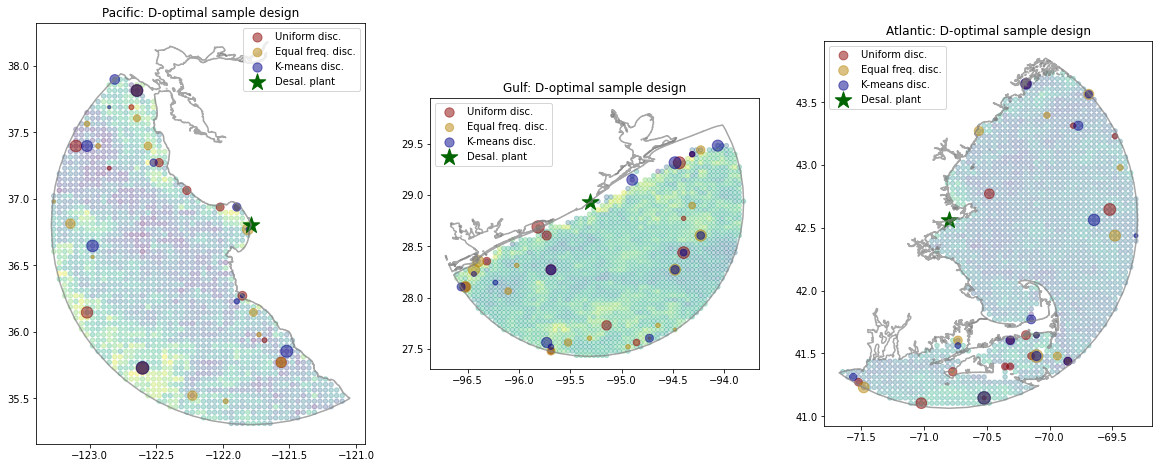

In [217]:
fig, ax = plt.subplots(ncols=3, figsize=(20,20))

# PAC
PAC[1].boundary.plot(ax=ax[0], alpha=0.7, color='gray') # background
PAC[0].plot(ax=ax[0], column='months_below_mean', alpha=0.3, markersize=20)
PAC[3].plot(ax=ax[0], color='darkred', markersize=PAC[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
PAC[4].plot(ax=ax[0], color='darkgoldenrod', markersize=PAC[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
PAC[5].plot(ax=ax[0], color='darkblue', markersize=PAC[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[0], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[0].set_title(f'Pacific: D-optimal sample design') #title
ax[0].legend()
# GUL
GUL[1].boundary.plot(ax=ax[1], alpha=0.7, color='gray') # background
GUL[0].plot(ax=ax[1], column='months_below_mean', alpha=0.3, markersize=20)
GUL[3].plot(ax=ax[1], color='darkred', markersize=GUL[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
GUL[4].plot(ax=ax[1], color='darkgoldenrod', markersize=GUL[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
GUL[5].plot(ax=ax[1], color='darkblue', markersize=GUL[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[1], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[1].set_title(f'Gulf: D-optimal sample design') #title
ax[1].legend()

# ATL
ATL[1].boundary.plot(ax=ax[2], alpha=0.7, color='gray') # background
ATL[0].plot(ax=ax[2], column='months_below_mean', alpha=0.3, markersize=20)
ATL[3].plot(ax=ax[2], color='darkred', markersize=ATL[3].n_samples*5, alpha=0.5, label='Uniform disc.') # sample points
ATL[4].plot(ax=ax[2], color='darkgoldenrod', markersize=ATL[4].n_samples*5, alpha=0.5, label='Equal freq. disc.') # sample points
ATL[5].plot(ax=ax[2], color='darkblue', markersize=ATL[5].n_samples*5, alpha=0.5, label='K-means disc.') # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[2], color='darkgreen', markersize=300, marker='*', label='Desal. plant') # desalination plant
ax[2].set_title(f'Atlantic: D-optimal sample design') #title
ax[2].legend()

plt.show()